<a href="https://colab.research.google.com/github/srinivaschintu485/srinivas-pendotagaya/blob/main/scenario2_Final_R3_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Asumptions**
We have assumed green colored blocks as soda can position and soda can drop off location

We have assumed red blocks as recharge stations

We have assumed grey colored block as hole

# **Iitializing Libraries**

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# **Generating 8x5x2 Grid**
# **matrix[0][3] Start**

In [35]:
import csv
import random
filename = "world.csv"
rows = 8
cols = 5
# initialize the matrix with zeros
matrix = [[0 for _ in range(cols)] for _ in range(rows)]
# set specific cells to specified values
matrix[0][4] = 4
matrix[0][0] = 1
matrix[1][2] = 3
matrix[3][2] = 2
matrix[6][3] = 2
matrix[2][4] = 2
matrix[2][0] = 2
#matrix[random.randint(0, rows-1)][ random.randint(0, cols-1)] = 4

# write the matrix to the CSV file
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(matrix)

print(f"{filename} has been generated.")

world.csv has been generated.


class ADPLearner:
    def __init__(self, s, a, g=0.9, e=0.9, chi=0.99):
        self.s = s
        self.a = a
        self.g = g
        self.e = e
        self.chi = chi

        self.u_table = np.zeros(s)
        self.r_table = np.zeros(s)
        self.p_table = np.zeros((s, a, s))
        self.cur_policy = np.random.randint(a, size=s)
        self.visited_state = np.zeros(s)
        self.count_action = np.zeros((s, a))
        self.count_outcome = np.zeros((s, a, s))

    def percept(self, s, a, pri, r):
        if self.visited_state[pri] == 0:
            self.u_table[pri] = r
            self.r_table[pri] = r
            self.visited_state[pri] = 1
        self.count_action[s, a] += 1
        self.count_outcome[s, a, pri] += 1
        self.p_table[s, a] = self.count_outcome[s, a] / self.count_action[s, a]

    def actuate(self, pri):
        if np.random.uniform() <= self.e:
            return np.random.randint(self.a)
        else:
            return self.cur_policy[pri]

    def policy_update(self):
        solver = PolicyIteration(self.r_table, self.p_table, self.g,
                                 init_policy=self.cur_policy, init_value=self.u_table)
        solver.train(tol=1e-3, plot=False)
        self.cur_policy = solver.policy
        self.e *= self.chi


# **Policy Iteration**

In [36]:
class PolicyIteration:
    def __init__(self, r_f, t_m, g, i_p=None, i_v=None):
        self.num_states = t_m.shape[0]
        self.num_actions = t_m.shape[1]
        self.r_f = np.nan_to_num(r_f)

        self.t_m = t_m
        self.g = g

        if i_v is None:
            self.values = np.zeros(self.num_states)
        else:
            self.values = i_v
        if i_p is None:
            self.policy = np.random.randint(0, self.num_actions, self.num_states)
        else:
            self.policy = i_p

    def one_policy_evaluation(self):
        delta = 0
        for s in range(self.num_states):
            temp = self.values[s]
            a = self.policy[s]
            p = self.t_m[s, a]
            self.values[s] = self.r_f[s] + self.g * np.sum(p * self.values)
            delta = max(delta, abs(temp - self.values[s]))
        return delta

    def run_policy_evaluation(self, t=1e-3):
        epoch = 0
        delta = self.one_policy_evaluation()
        delta_history = [delta]
        while epoch < 500:
            delta = self.one_policy_evaluation()
            delta_history.append(delta)
            if delta < t:
                break
        return len(delta_history)

    def run_policy_improvement(self):
        update_policy_count = 0
        for s in range(self.num_states):
            temp = self.policy[s]
            v_list = np.zeros(self.num_actions)
            for a in range(self.num_actions):
                p = self.t_m[s, a]
                v_list[a] = np.sum(p * self.values)
            self.policy[s] = np.argmax(v_list)
            if temp != self.policy[s]:
                update_policy_count += 1
        return update_policy_count

    def train(self, t=1e-3, plot=True):
        epoch = 0
        eval_count_history = []
        policy_change_history = []
        while epoch < 500:
            epoch += 1
            eval_count = self.run_policy_evaluation(t)
            policy_change = self.run_policy_improvement()
            eval_count_history.append(eval_count)
            policy_change_history.append(policy_change)
            if policy_change == 0:
                break

        if plot is True:
            fig, axes = plt.subplots(2, 1, figsize=(3.5, 4), sharex='all', dpi=200)
            axes[0].plot(np.arange(len(eval_count_history)), eval_count_history, marker='o', markersize=4, alpha=0.7,
                         color='#2ca02c', label='# sweep in \npolicy evaluation\n' + r'$g =$' + f'{self.g}')
            axes[0].legend()

            axes[1].plot(np.arange(len(policy_change_history)), policy_change_history, marker='o',
                         markersize=4, alpha=0.7, color='#d62728',
                         label='# policy updates in \npolicy improvement\n' + r'$g =$' + f'{self.g}')
            axes[1].set_xlabel('The number of epochs')
            axes[1].legend()
            plt.tight_layout()
            plt.show()



# **Grid World**

In [37]:
class G_W:
    def __init__(self, filename, r_d, r_r, t_l=1000):
        file = open(filename)
        self.map = np.array(
            [list(map(float, s.strip().split(","))) for s in file.readlines()]
        )
        file.close()
        self.n_r = self.map.shape[0]
        self.n_c = self.map.shape[1]
        self.n_s = self.n_r * self.n_c
        self.n_a = 4
        self.r_d = r_d
        self.r_r = r_r
        self.t_l = t_l
        self.r_d_function = self.get_r_d_function()
        self.t_m= self.get_t_m()

    def g_s_f_p(self, pos):
        return pos[0] * self.n_c + pos[1]

    def get_pos_from_state(self, state):
        return state // self.n_c, state % self.n_c

    def get_r_d_function(self):
        r_d_table = np.zeros(self.n_s)
        for r in range(self.n_r):
            for c in range(self.n_c):
                s = self.g_s_f_p((r, c))
                r_d_table[s] = self.r_d[self.map[r, c]]
        return r_d_table

    def get_t_m(self):
        t_m= np.zeros((self.n_s, self.n_a, self.n_s))
        for r in range(self.n_r):
            for c in range(self.n_c):
                s = self.g_s_f_p((r, c))
                n_S= np.zeros(self.n_a)
                if self.map[r, c] == 0:
                    for a in range(self.n_a):
                        new_r, new_c = r, c
                        if a == 0:
                            new_r = max(r - 1, 0)
                        elif a == 1:
                            new_c = min(c + 1, self.n_c - 1)
                        elif a == 2:
                            new_r = min(r + 1, self.n_r - 1)
                        elif a == 3:
                            new_c = max(c - 1, 0)
                        if self.map[new_r, new_c] == 3:
                            new_r, new_c = r, c
                        s_prime = self.g_s_f_p((new_r, new_c))
                        n_S[a] = s_prime
                else:
                    n_S= np.ones(self.n_a) * s
                for a in range(self.n_a):
                    t_m[s, a, int(n_S[a])] += 1 - self.r_r
                    t_m[s, a, int(n_S[(a + 1) % self.n_a])] += self.r_r / 2.0
                    t_m[s, a, int(n_S[(a - 1) % self.n_a])] += self.r_r / 2.0
        return t_m

    def generate_random_p_y(self):
        return np.random.randint(self.n_a, size=self.n_s)

    def e_p(self, p_y, s_p):
        s = self.g_s_f_p(s_p)
        r = self.r_d_function[s]
        total_r_d = r

        s_t = int(round(time() * 1000))
        overtime = False

        while r != self.r_d[1] and r != self.r_d[2]:
            s = np.random.choice(self.n_s, p=self.t_m[s, p_y[s]])
            r = self.r_d_function[s]
            total_r_d += r
            cur_time = int(round(time() * 1000)) - s_t
            if cur_time > self.t_l:
                overtime = True
                break
        if overtime is True:
            return float('-inf')
        else:
            return total_r_d

    def random_start_p_y(self, p_y, s_p, n=100, plot=True):
        s_t = int(round(time() * 1000))
        overtime = False
        marks = np.zeros(n)
        i = 0
        while i < n:
            temp = self.e_p(p_y=p_y, s_p=s_p)
            count=i
            print(f'count = {count} Outcome: {temp}')
            if temp > float('-inf'):
                marks[i] = temp
                i += 1
            cur_time = int(round(time() * 1000)) - s_t
            if cur_time > n * self.t_l:
                overtime = True
                break

        print(f'max = {np.max(marks)}')
        print(f'min = {np.min(marks)}')
        print(f'mean = {np.mean(marks)}')
        print(f'std = {np.std(marks)}')

        if overtime is False and plot is True:
            bins = 100
            fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
            ax.set_xlabel('In a single game whole rewards')
            ax.set_ylabel('Frequency')
            ax.hist(marks, bins=bins, color='#1f77b4', edgecolor='black')
            plt.show()

        if overtime is True:
            print('Overtime!')
            return None
        else:
            return np.max(marks), np.min(marks), np.mean(marks)

    def blackbox_move(self, s, a):
        temp = self.t_m[s, a]
        s_prime = np.random.choice(self.n_s, p=temp)
        r = self.r_d_function[s_prime]
        return s_prime, r

    def plot_map(self, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.n_r, fig_size[0] // self.n_c)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.n_c + 1):
            if i == 0 or i == self.n_c:
                ax.plot([i * unit, i * unit], [0, self.n_r * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.n_r * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.n_r + 1):
            if i == 0 or i == self.n_r:
                ax.plot([0, self.n_c * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.n_c * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.n_r):
            for j in range(self.n_c):
                y = (self.n_r - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

    def plot_p_y(self, p_y, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.n_r, fig_size[0] // self.n_c)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.n_c + 1):
            if i == 0 or i == self.n_c:
                ax.plot([i * unit, i * unit], [0, self.n_r * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.n_r * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.n_r + 1):
            if i == 0 or i == self.n_r:
                ax.plot([0, self.n_c * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.n_c * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.n_r):
            for j in range(self.n_c):
                y = (self.n_r - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 4:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                s = self.g_s_f_p((i, j))
                if self.map[i, j] == 0:
                    a = p_y[s]
                    symbol = ['^', '>', 'v', '<']
                    ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a],
                            linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()

    def visualize_value_p_y(self, p_y, values, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.n_r, fig_size[0] // self.n_c)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')

        for i in range(self.n_c + 1):
            if i == 0 or i == self.n_c:
                ax.plot([i * unit, i * unit], [0, self.n_r * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.n_r * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.n_r + 1):
            if i == 0 or i == self.n_r:
                ax.plot([0, self.n_c * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.n_c * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.n_r):
            for j in range(self.n_c):
                y = (self.n_r - 1 - i) * unit
                x = j * unit
                s = self.g_s_f_p((i, j))
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 4:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                if self.map[i, j] != 3:
                    ax.text(x + 0.5 * unit, y + 0.5 * unit, f'{values[s]:.4f}',
                            horizontalalignment='center', verticalalignment='center',
                            fontsize=max(fig_size)*unit*0.6)
                if p_y is not None:
                    if self.map[i, j] == 0:
                        a = p_y[s]
                        symbol = ['^', '>', 'v', '<']
                        ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a], alpha=0.4,
                                linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()


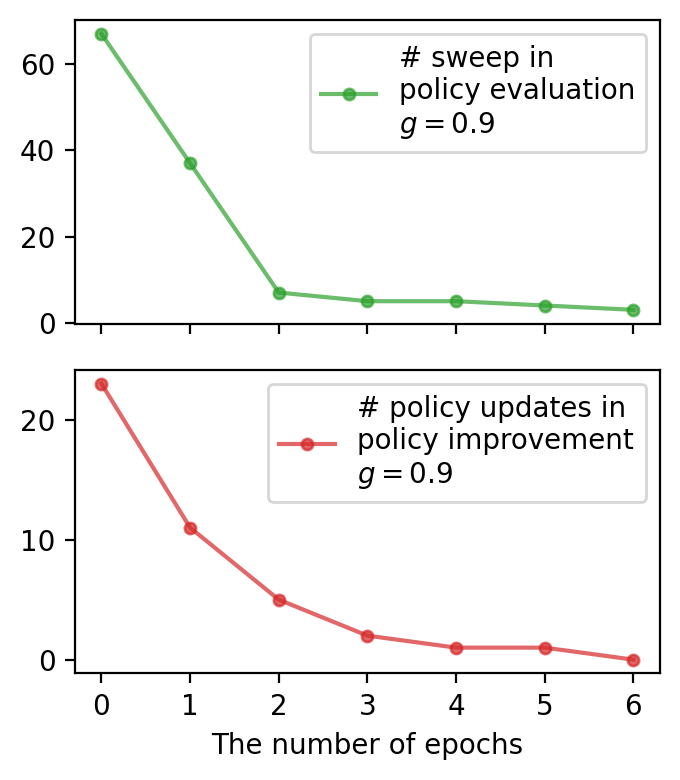

In [38]:
import numpy as np
problem = G_W('world.csv', r_d={0: -0.1, 4: 0.1, 2: -0.2, 3: np.NaN,1:1}, r_r=0.1)
policy = [1, 1, 3, 1, 0, 0, 2, 0, 1, 2, 1, 0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
solver = PolicyIteration(problem.r_d_function, problem.t_m, g=0.9, i_p=policy)
solver.train()


<ipython-input-37-e1f4d0ec6a69>:270: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


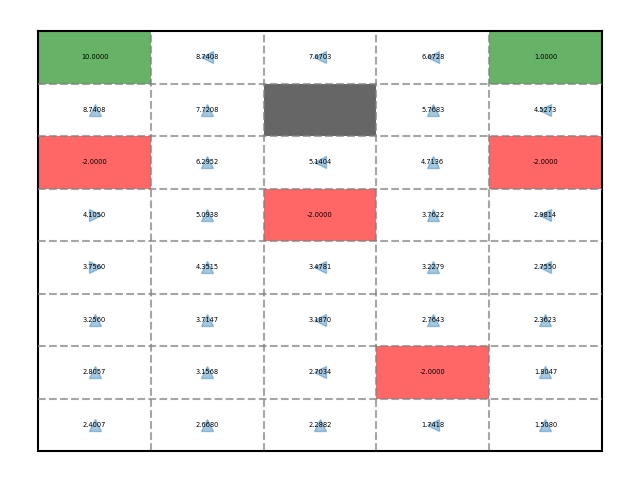

count = 0 Outcome: 1.0
count = 1 Outcome: 1.0
count = 2 Outcome: 1.0
count = 3 Outcome: 1.0
count = 4 Outcome: 1.0
count = 5 Outcome: 1.0
count = 6 Outcome: 1.0
count = 7 Outcome: 1.0
count = 8 Outcome: 1.0
count = 9 Outcome: 1.0
count = 10 Outcome: 1.0
count = 11 Outcome: 1.0
count = 12 Outcome: 1.0
count = 13 Outcome: 1.0
count = 14 Outcome: 1.0
count = 15 Outcome: 1.0
count = 16 Outcome: 1.0
count = 17 Outcome: 1.0
count = 18 Outcome: 1.0
count = 19 Outcome: 1.0
count = 20 Outcome: 1.0
count = 21 Outcome: 1.0
count = 22 Outcome: 1.0
count = 23 Outcome: 1.0
count = 24 Outcome: 1.0
count = 25 Outcome: 1.0
count = 26 Outcome: 1.0
count = 27 Outcome: 1.0
count = 28 Outcome: 1.0
count = 29 Outcome: 1.0
count = 30 Outcome: 1.0
count = 31 Outcome: 1.0
count = 32 Outcome: 1.0
count = 33 Outcome: 1.0
count = 34 Outcome: 1.0
count = 35 Outcome: 1.0
count = 36 Outcome: 1.0
count = 37 Outcome: 1.0
count = 38 Outcome: 1.0
count = 39 Outcome: 1.0
count = 40 Outcome: 1.0
count = 41 Outcome: 1.0
co

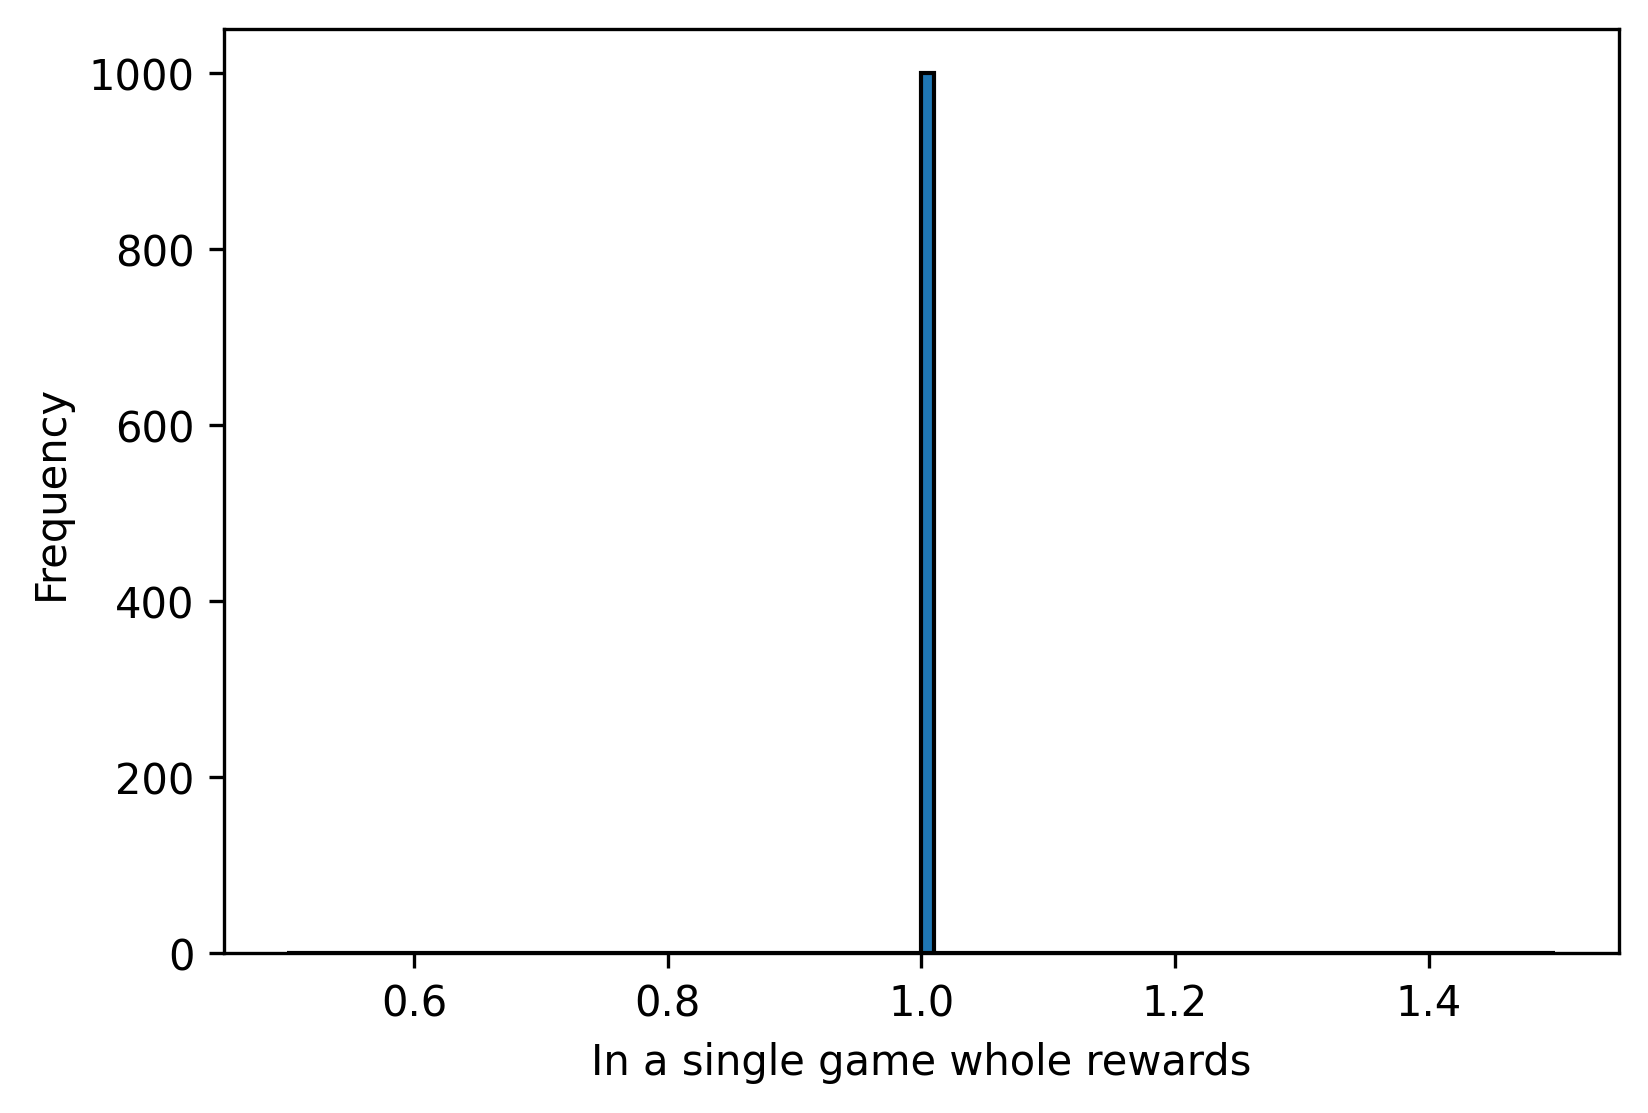

(1.0, 1.0, 1.0)

In [39]:
problem.visualize_value_p_y(p_y=solver.policy, values=solver.values)
problem.random_start_p_y(p_y=solver.policy, s_p=(0, 0), n=1000)